In [1]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 

# Data Splitting 
import os.path
import argparse
import random
import datetime as dt
import copy

# Data Augmentation 
import PIL

In [2]:
#For Keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import regularizers, optimizers

Using TensorFlow backend.


## Dataset Preparation

In [3]:
dataset_path = './data'
anns_file_path = dataset_path + '/' + 'annotations.json'

In [4]:
# Read Annotations
with open(anns_file_path , 'r') as f:
    dataset = json.loads(f.read())

In [5]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

print(nr_images) # Total Number of images

1500


In [7]:
cat_df = pd.DataFrame(categories)

In [18]:
# category Dataframe and  Select 'six new Category(ouput classes)' for category Dataframe
keyValList = ['Cigarette','Paper cup','Unlabeled litter','Clear plastic bottle','Drink can']
category_df = pd.DataFrame([d for d in categories if d['name'] in keyValList])

# Annotation Dataframe
ann_df = pd.DataFrame(anns)
# Images Dataframe
image_df = pd.DataFrame(imgs)


In [29]:
image_df.head()

,id,width,height,file_name
0,0,1537,2049,batch_1/000006.jpg
1,1,1537,2049,batch_1/000008.jpg
2,2,1537,2049,batch_1/000010.jpg
3,3,2049,1537,batch_1/000019.jpg
4,4,1537,2049,batch_1/000026.jpg


In [19]:
# Dropping unncessary columns for Keras fundamental CNN model
category_df = category_df.drop(['supercategory'], axis = 1)
image_df = image_df.drop(['license','flickr_url','coco_url','date_captured','flickr_640_url'], axis=1)
ann_df = ann_df.drop(['id'], axis=1)

In [20]:
merged_img_ann_df = pd.merge(left=image_df, right=ann_df, left_on='id', right_on='image_id')
final_merged_df = pd.merge(left=merged_img_ann_df, right=category_df, left_on='category_id', right_on='id') 
final_merged_df = final_merged_df.drop(['id_x','id_y','category_id','image_id','width','height'], axis = 1 )


In [21]:
final_merged_df

,file_name,segmentation,area,bbox,iscrowd,name
0,batch_1/000010.jpg,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",73832.5,"[632.0, 987.0, 500.0, 374.0]",0,Clear plastic bottle
1,batch_1/000019.jpg,"[[354.0, 1268.0, 351.0, 1252.0, 347.0, 1237.0,...",98379.5,"[209.0, 920.0, 454.0, 562.0]",0,Clear plastic bottle
2,batch_1/000019.jpg,"[[1239.0, 841.0, 1247.0, 842.0, 1252.0, 835.0,...",43678.0,"[1212.0, 822.0, 179.0, 446.0]",0,Clear plastic bottle
3,batch_1/000001.jpg,"[[1062.0, 752.0, 1123.0, 744.0, 1153.0, 744.0,...",68667.0,"[826.0, 744.0, 464.0, 205.0]",0,Clear plastic bottle
4,batch_1/000005.jpg,"[[825.0, 731.0, 824.0, 670.0, 825.0, 649.0, 82...",17734.0,"[824.0, 557.0, 89.0, 236.0]",0,Clear plastic bottle
...,...,...,...,...,...,...
1760,batch_9/000090.jpg,"[[1482, 1732, 1505, 1710, 1566, 1733, 1579, 17...",3575.0,"[1482.0, 1710.0, 97.0, 59.0]",0,Unlabeled litter
1761,batch_9/000095.jpg,"[[435, 1444, 453, 1493, 484, 1492, 509, 1480, ...",3100.0,"[435.0, 1439.0, 79.0, 54.0]",0,Unlabeled litter
1762,batch_9/000095.jpg,"[[401, 1896, 421, 1846, 478, 1847, 576, 1892, ...",8854.5,"[401.0, 1846.0, 175.0, 93.0]",0,Unlabeled litter
1763,batch_9/000095.jpg,"[[637, 3871, 629, 3812, 614, 3770, 632, 3712, ...",9563.0,"[614.0, 3712.0, 93.0, 159.0]",0,Unlabeled litter


In [22]:
final_merged_df = final_merged_df.rename(columns={"file_name": "filename", "name": "category"})
final_merged_df.head()


,filename,segmentation,area,bbox,iscrowd,category
0,batch_1/000010.jpg,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",73832.5,"[632.0, 987.0, 500.0, 374.0]",0,Clear plastic bottle
1,batch_1/000019.jpg,"[[354.0, 1268.0, 351.0, 1252.0, 347.0, 1237.0,...",98379.5,"[209.0, 920.0, 454.0, 562.0]",0,Clear plastic bottle
2,batch_1/000019.jpg,"[[1239.0, 841.0, 1247.0, 842.0, 1252.0, 835.0,...",43678.0,"[1212.0, 822.0, 179.0, 446.0]",0,Clear plastic bottle
3,batch_1/000001.jpg,"[[1062.0, 752.0, 1123.0, 744.0, 1153.0, 744.0,...",68667.0,"[826.0, 744.0, 464.0, 205.0]",0,Clear plastic bottle
4,batch_1/000005.jpg,"[[825.0, 731.0, 824.0, 670.0, 825.0, 649.0, 82...",17734.0,"[824.0, 557.0, 89.0, 236.0]",0,Clear plastic bottle


In [23]:
# For batch 1 , later add for loop for all 15 batches
#batch1_df = df[df['file_name'].str.contains(r'batch_1/(?!$)')]
#batch1_df = batch1_df[batch1_df['file_name'].str.contains(r'/0(?!$)')]
#batch1_df['filename'] = batch1_df['filename'].map(lambda x: x.lstrip('batch_1/'))

# First Part using Kears data generation

In [24]:
train_df = final_merged_df[['filename','category']]
train_df = train_df.drop_duplicates(subset='filename')

In [25]:
train_df['category'].value_counts()
#sns.countplot(x='name', data=df)

Clear plastic bottle    225
Cigarette               152
Unlabeled litter        133
Drink can               128
Paper cup                49
Name: category, dtype: int64

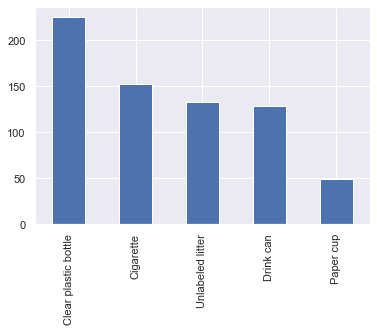

In [28]:
train_df['category'].value_counts().plot.bar()

In [140]:
# Data splitting into train and test data and keep this test data aside for model prediction
trainData_df, testData_df = train_test_split(train_df, test_size=0.20, random_state=42,stratify = train_df['category'] )
trainData_df = trainData_df.reset_index(drop=True)
testData_df = testData_df.reset_index(drop=True)

In [141]:
trainData_df['category'].value_counts()

Clear plastic bottle    180
Cigarette               122
Unlabeled litter        106
Drink can               102
Paper cup                39
Name: category, dtype: int64

In [142]:
total_train = trainData_df.shape[0]
total_test = testData_df.shape[0]
batch_size=1

In [143]:
total_test

138

In [144]:
# Define Constants
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [145]:
# generic image data generator 
datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.25
)

In [146]:
# Train image data generator
# Create new train folder directory which should have images for batch 1
train_generator=datagen.flow_from_dataframe(
    dataframe=trainData_df,
    directory="./data/",
    x_col="filename",
    y_col="category",
    subset="training",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=IMAGE_SIZE
)


Found 412 validated image filenames belonging to 5 classes.


In [147]:
# Validation image data generator
valid_generator=datagen.flow_from_dataframe(
    dataframe=trainData_df,
    directory="./data/",
    x_col="filename",
    y_col="category",
    subset="validation",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=IMAGE_SIZE
)

Found 137 validated image filenames belonging to 5 classes.


In [148]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=testData_df,
    directory="./data/",
    x_col="filename",
    y_col=None,
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=IMAGE_SIZE
)

Found 138 validated image filenames.


In [149]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))


In [150]:
#Model Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)       

In [151]:
# Compile Model
model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

In [152]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

Epoch 1/10
412/412 [==============================] - 268s 650ms/step - loss: 1.5959 - accuracy: 0.3058 - val_loss: 28.8359 - val_accuracy: 0.0584
Epoch 2/10
412/412 [==============================] - 255s 620ms/step - loss: 1.5697 - accuracy: 0.3180 - val_loss: 71.8231 - val_accuracy: 0.0511
Epoch 3/10
412/412 [==============================] - 227s 552ms/step - loss: 1.5497 - accuracy: 0.3180 - val_loss: 8.4274 - val_accuracy: 0.0730
Epoch 4/10
412/412 [==============================] - 224s 544ms/step - loss: 1.5386 - accuracy: 0.3180 - val_loss: 157.6800 - val_accuracy: 0.1168
Epoch 5/10
412/412 [==============================] - 4447s 11s/step - loss: 1.5353 - accuracy: 0.3180 - val_loss: 52.7841 - val_accuracy: 0.1533
Epoch 6/10
412/412 [==============================] - 275s 668ms/step - loss: 1.5308 - accuracy: 0.3180 - val_loss: 74.7286 - val_accuracy: 0.1168
Epoch 7/10
412/412 [==============================] - 327s 793ms/step - loss: 1.5321 - accuracy: 0.3180 - val_loss: 75.

In [51]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
STEP_SIZE_TEST

138

In [52]:
model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_TEST)

[100.31158447265625, 0.18115942180156708]

In [53]:
test_generator.reset()
pred=model.predict_generator(test_generator,steps=STEP_SIZE_TEST,
verbose= 1)

138/138 [==============================] - 33s 236ms/step


In [54]:
predicted_class_indices=np.argmax(pred,axis=1)

In [55]:
labels = (train_generator.class_indices)
labels

{'Cigarette': 0,
 'Clear plastic bottle': 1,
 'Drink can': 2,
 'Paper cup': 3,
 'Unlabeled litter': 4}

In [56]:
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [57]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,"Predictions":predictions})

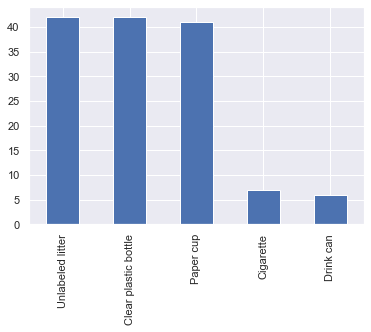

In [58]:
results['Predictions'].value_counts().plot.bar()

# Second Approach by loading images    , ( Still not decide to use)

In [319]:
batch1_df.shape[0]

101

In [ ]:
# loading and preparing training images
train_image = []
dataset_path = './data/batch_1'

for j in range(15):
    for i in tqdm(range(batch1_df.shape[0])):
    #for filename in listdir(dataset_path): # both are working
        #img = image.load_img('data/'+1+batch1_df['filename'][i]+'.jpg',target_size=(400,400,3))
        img = image.load_img('data/batch_'+ j +'/'+filename,target_size=(400,400,3))
        img = image.img_to_array(img)
        img = img/255
        train_image.append(img)
    X = np.array(train_image)

In [773]:
X.shape

(101, 400, 400, 3)

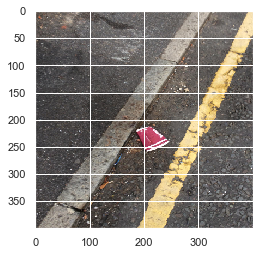

In [322]:
plt.imshow(X[2])

In [323]:
batch1_df

,filename,name
0,000006.jpg,Glass bottle
1,000012.jpg,Glass bottle
2,000048.jpg,Glass bottle
3,000021.jpg,Glass bottle
4,000022.jpg,Glass bottle
...,...,...
3942,000119.JPG,Food waste
3954,000093.JPG,Spread tub
3969,000096.JPG,Garbage bag
4067,000064.JPG,Foam cup


In [324]:
batch1_df = pd.get_dummies(batch1_df, columns=["name"])

In [325]:
batch1_df

,filename,name_Aerosol,name_Cigarette,name_Clear plastic bottle,name_Crisp packet,name_Disposable food container,name_Drink can,name_Egg carton,name_Foam cup,name_Food Can,...,name_Other carton,name_Other plastic bottle,name_Paper bag,name_Paper cup,name_Plastic bottle cap,name_Plastic film,name_Plastic lid,name_Single-use carrier bag,name_Spread tub,name_Styrofoam piece
0,000006.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000012.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,000048.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000021.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,000022.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3942,000119.JPG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3954,000093.JPG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3969,000096.JPG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4067,000064.JPG,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [328]:
# Dropping name from dataframe because we have name_cat for labels in batch1 
y = np.array(batch1_df.drop(['filename'],axis=1))
y.shape

(101, 26)

In [329]:
# Data split Randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [348]:
# Build keras model architecture
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(400,400,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(26, activation='softmax'))

In [349]:
#Model Summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 396, 396, 16)      1216      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 198, 198, 16)      0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 198, 198, 16)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 194, 194, 32)      12832     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 97, 97, 32)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 93, 93, 64)      

In [350]:
# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mean_absolute_error'])

In [351]:
# Model fit
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=64)

Train on 90 samples, validate on 11 samples
Epoch 1/5
90/90 [==============================] - 38s 423ms/step - loss: 3.5647 - mean_absolute_error: 0.0740 - val_loss: 3.2374 - val_mean_absolute_error: 0.0739
Epoch 2/5
90/90 [==============================] - 27s 299ms/step - loss: 3.3730 - mean_absolute_error: 0.0740 - val_loss: 3.2534 - val_mean_absolute_error: 0.0740
Epoch 3/5
90/90 [==============================] - 23s 251ms/step - loss: 3.2494 - mean_absolute_error: 0.0739 - val_loss: 3.2507 - val_mean_absolute_error: 0.0739
Epoch 4/5
90/90 [==============================] - 23s 255ms/step - loss: 3.2452 - mean_absolute_error: 0.0739 - val_loss: 3.2375 - val_mean_absolute_error: 0.0739
Epoch 5/5
90/90 [==============================] - 37s 406ms/step - loss: 3.2291 - mean_absolute_error: 0.0738 - val_loss: 3.2088 - val_mean_absolute_error: 0.0738
